In [1]:
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

#Data loading and preliminary analysis

Path to dataset files: /root/.cache/kagglehub/datasets/camnugent/california-housing-prices/versions/1
Basic info of Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None

Missing value:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
tota

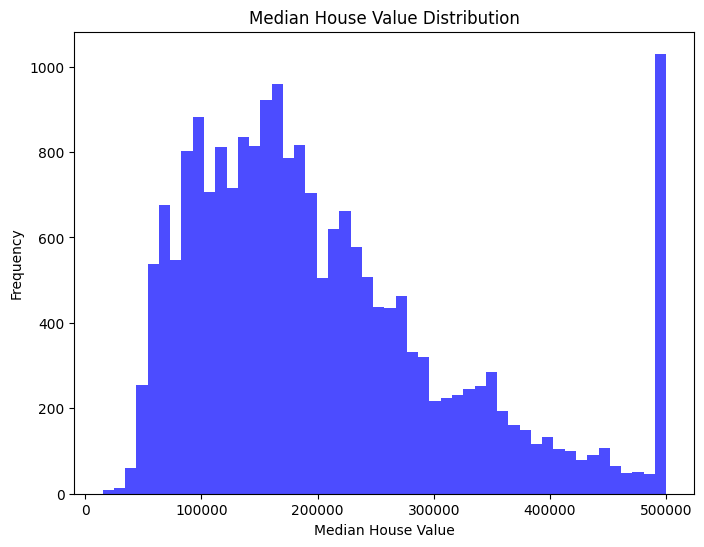

In [2]:
# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)

file_path = f"{path}/housing.csv"
housing_data = pd.read_csv(file_path)

# Basic info
print("Basic info of Data:")
print(housing_data.info())

# Check missing
missing_values = housing_data.isnull().sum()
print("\nMissing value:")
print(missing_values)

# preview data
print("\nFirst 5 rows:")
print(housing_data.head())

# visualization
plt.figure(figsize=(8, 6))
plt.hist(housing_data['median_house_value'], bins=50, color='blue', alpha=0.7)
plt.title('Median House Value Distribution')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

#Data Processing
##Handling missing values ​and partitioning the dataset
##Fill the missing value with median value

In [3]:
# handle missing value with median value
median_bedrooms = housing_data['total_bedrooms'].median()
housing_data['total_bedrooms'].fillna(median_bedrooms, inplace=True)

# validate missing has been filled
print("Missing value (after processing):")
print(housing_data.isnull().sum())

Missing value (after processing):
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


<ipython-input-3-bfb673087f18>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_data['total_bedrooms'].fillna(median_bedrooms, inplace=True)


##Standardization and categorical feature processing

In [4]:
# Separating features and target variables
X = housing_data.drop(columns=['median_house_value'])
y = housing_data['median_house_value']

# Processing categorical features: ocean_proximity
X = pd.get_dummies(X, columns=['ocean_proximity'], drop_first=True)

# Split the dataset into training, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# standardizing Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# shape of 3 datasets
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (14448, 12)
Validation set: (3096, 12)
Test set: (3096, 12)


#Visualization of feature distribution
##Distribution of numerical features (training set)

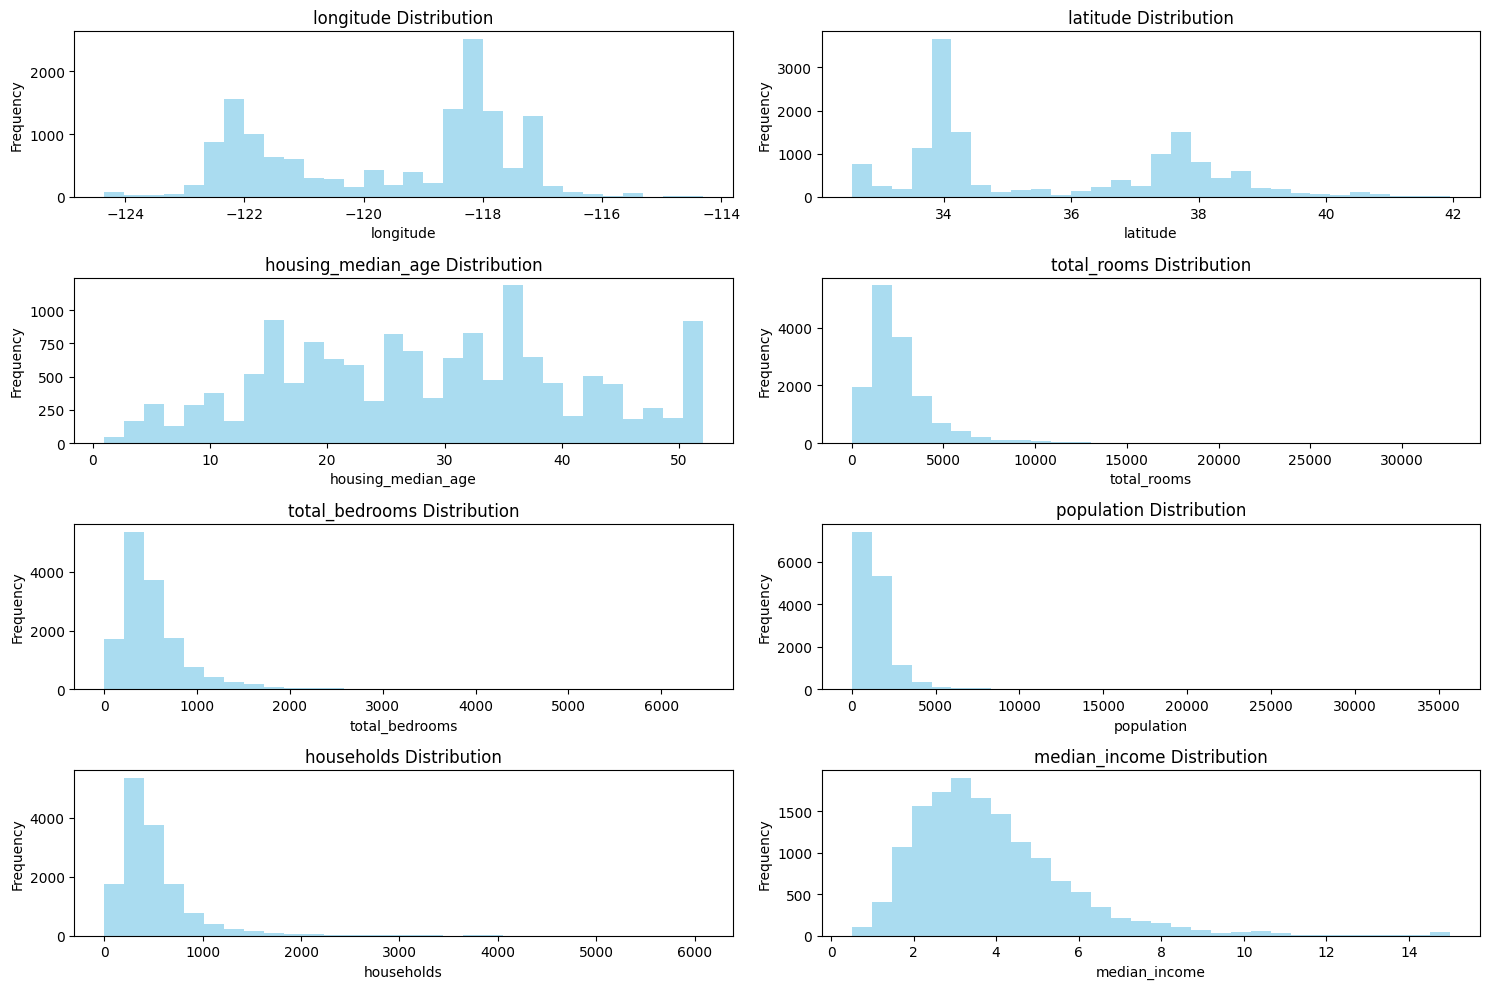

In [5]:
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                    'population', 'households', 'median_income']

# Visualization
fig, axes = plt.subplots(len(numeric_features)//2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    axes[i].hist(X_train[feature], bins=30, color='skyblue', alpha=0.7)
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#XGBoost model Training & Evaluation
##Model training and validation

In [6]:
# Initialize the XGBoost regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbosity=1)

# train model
model.fit(X_train_scaled, y_train)

# Predictions on the validation set
y_val_pred = model.predict(X_val_scaled)

# Calculate the error and accuracy of the validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)
val_accuracy = val_r2 * 100

# results
print(f"Validation set mean square error (MSE): {val_mse:.2f}")
print(f"Validation set root mean square error (RMSE): {val_rmse:.2f}")
print(f"Validation set coefficient of determination (R²): {val_accuracy:.2f}%")

Validation set mean square error (MSE): 2486622694.30
Validation set root mean square error (RMSE): 49866.05
Validation set coefficient of determination (R²): 80.91%


##Test set evaluation

In [7]:
# Predictions on the test set
y_test_pred = model.predict(X_test_scaled)

# Calculate the error and accuracy of the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_accuracy = test_r2 * 100

# Results
print(f"Test set mean square error (MSE): {test_mse:.2f}")
print(f"Test set root mean square error (RMSE): {test_rmse:.2f}")
print(f"Test set coefficient of determination (R²): {test_accuracy:.2f}%")

Test set mean square error (MSE): 2124066500.90
Test set root mean square error (RMSE): 46087.60
Test set coefficient of determination (R²): 83.94%


#Visualization of model prediction results
##True value vs predicted value of validation set and test set (scatter plot)

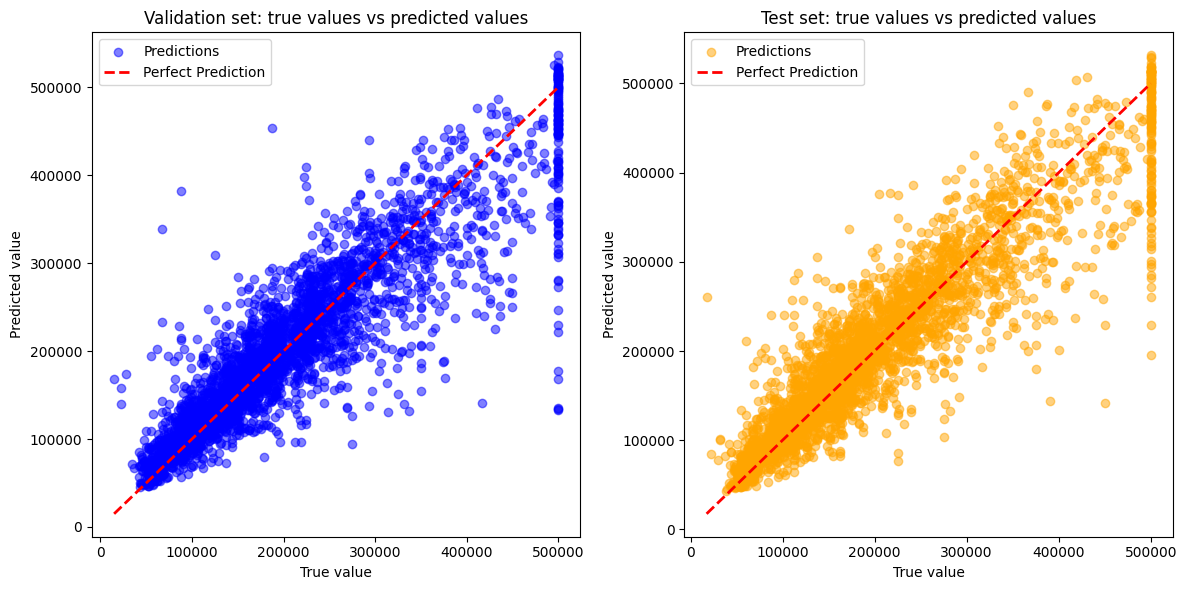

In [8]:
plt.figure(figsize=(12, 6))

# Validation set
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Predictions', color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Validation set: true values ​​vs predicted values')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.legend()

# Test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Predictions', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Test set: true values ​​vs predicted values')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.legend()

plt.tight_layout()
plt.show()

#Feature Importance Analysis
##Visualization of Feature Importance

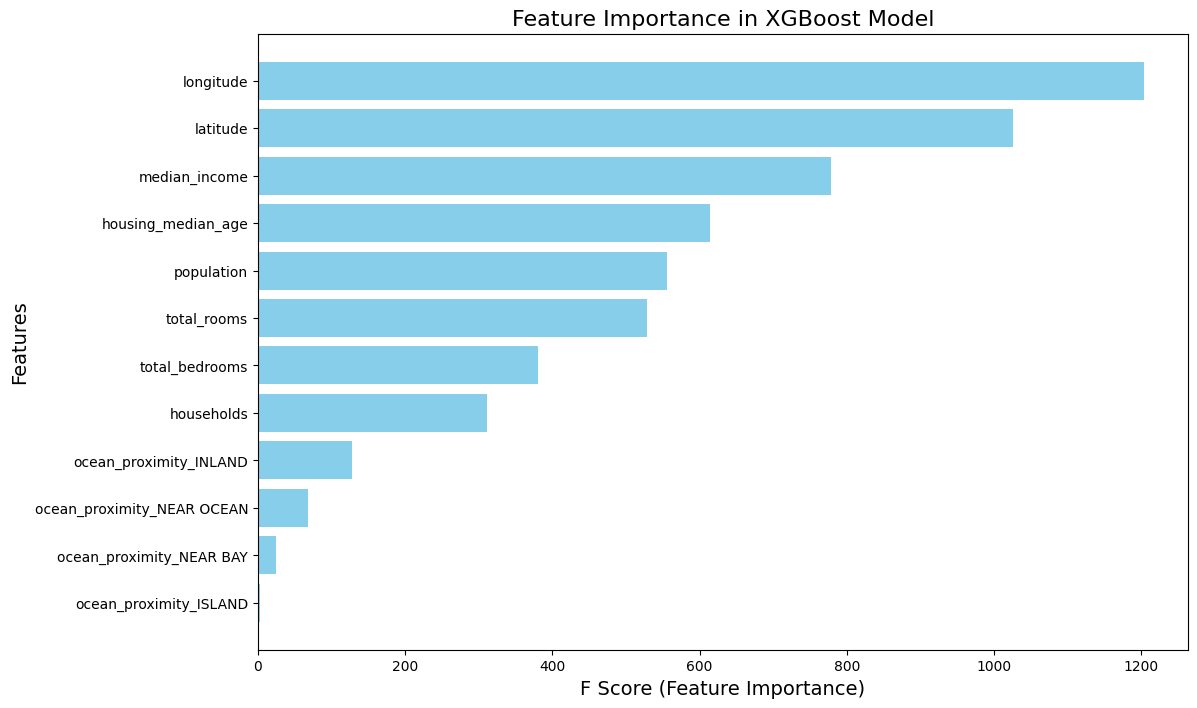

In [9]:
# Get feature importance scores
feature_importances = model.get_booster().get_score(importance_type='weight')

# Use original feature name
feature_names = X_train.columns
mapped_importances = {feature_names[int(key[1:])]: value for key, value in feature_importances.items()}

# Sort by importance
sorted_importances = sorted(mapped_importances.items(), key=lambda x: x[1], reverse=True)

# Extract name and score
features, scores = zip(*sorted_importances)

# Bar chart
plt.figure(figsize=(12, 8))
plt.barh(features, scores, color='skyblue')
plt.xlabel('F Score (Feature Importance)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance in XGBoost Model', fontsize=16)
plt.gca().invert_yaxis()
plt.show()

#Noise detected
##Check for clipping and outliers

Number of clipping and outliers: 992
The proportion of cropping and outliers in the total dataset: 4.81%


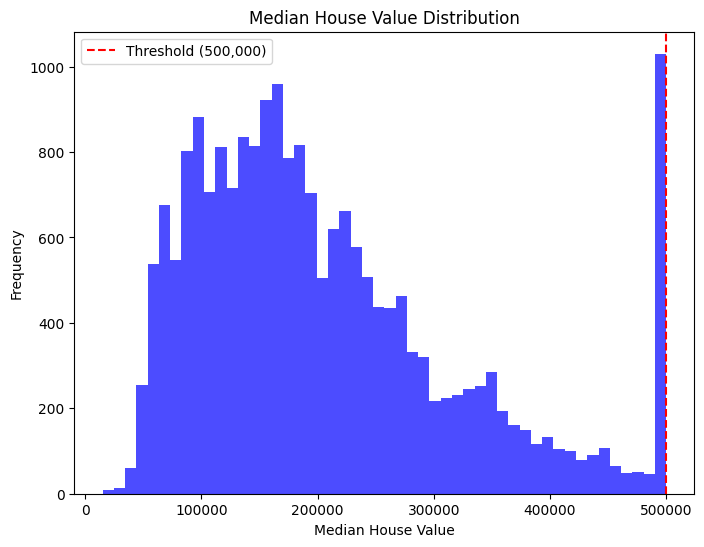

In [10]:
# Check for clipped values ​​in the target variable
clipped_count = (housing_data['median_house_value'] >= 500000).sum()
total_count = len(housing_data)

print(f"Number of clipping and outliers: {clipped_count}")
print(f"The proportion of cropping and outliers in the total dataset: {clipped_count / total_count * 100:.2f}%")

# Visualization
plt.figure(figsize=(8, 6))
plt.hist(housing_data['median_house_value'], bins=50, color='blue', alpha=0.7)
plt.axvline(500000, color='red', linestyle='--', label='Threshold (500,000)')
plt.title('Median House Value Distribution')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##Check the error of the clipping value

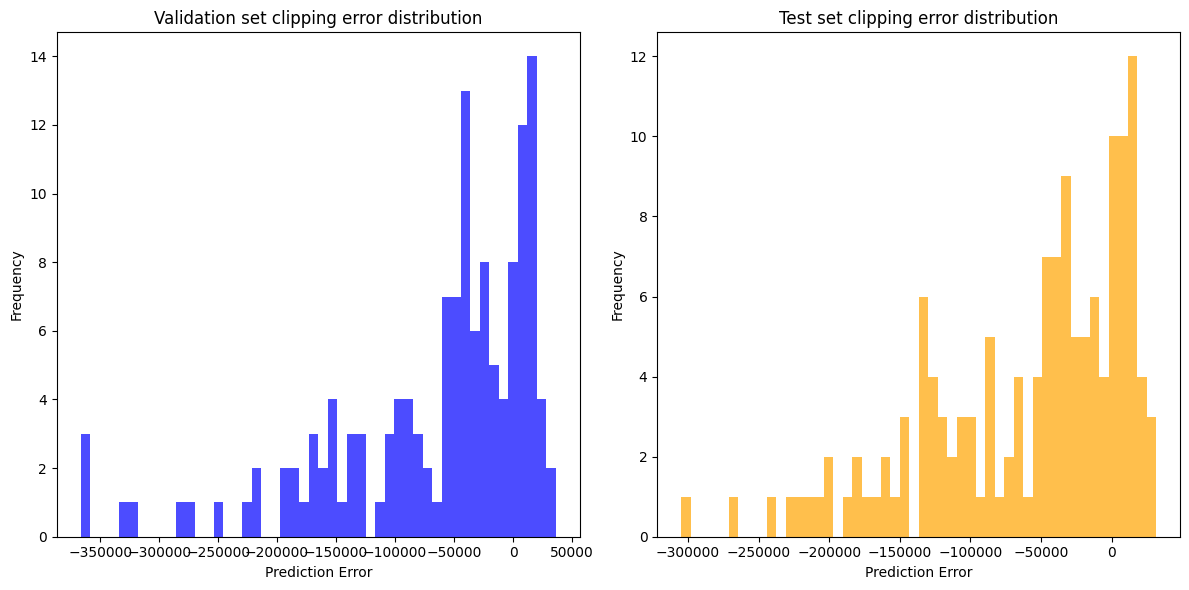

In [11]:
# Extracting the error of the clipping value (validation set and test set)
clipped_indices_val = y_val >= 500000
clipped_indices_test = y_test >= 500000

val_clipped_errors = y_val_pred[clipped_indices_val] - y_val[clipped_indices_val]
test_clipped_errors = y_test_pred[clipped_indices_test] - y_test[clipped_indices_test]

# Visualizing Error Distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(val_clipped_errors, bins=50, color='blue', alpha=0.7)
plt.title('Validation set clipping error distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_clipped_errors, bins=50, color='orange', alpha=0.7)
plt.title('Test set clipping error distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#Cleaning Data
##Remove clipping and outliers

In [12]:
# Remove clipping and outliers
housing_data_cleaned = housing_data[housing_data['median_house_value'] < 500000]

# Check the cleaned data
print(f"Size of the dataset after cleaning: {len(housing_data_cleaned)}")
print(f"The percentage of deleted data: {(total_count - len(housing_data_cleaned)) / total_count * 100:.2f}%")

Size of the dataset after cleaning: 19648
The percentage of deleted data: 4.81%


##Repartitioning the dataset

In [13]:
X_cleaned = housing_data_cleaned.drop(columns=['median_house_value'])
y_cleaned = housing_data_cleaned['median_house_value']

# One-Hot encoding and standardization
X_cleaned = pd.get_dummies(X_cleaned, columns=['ocean_proximity'], drop_first=True)
X_train_cleaned, X_temp_cleaned, y_train_cleaned, y_temp_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42)
X_val_cleaned, X_test_cleaned, y_val_cleaned, y_test_cleaned = train_test_split(X_temp_cleaned, y_temp_cleaned, test_size=0.5, random_state=42)

scaler_cleaned = StandardScaler()
X_train_cleaned_scaled = scaler_cleaned.fit_transform(X_train_cleaned)
X_val_cleaned_scaled = scaler_cleaned.transform(X_val_cleaned)
X_test_cleaned_scaled = scaler_cleaned.transform(X_test_cleaned)

#Retrain the model and evaluate
##Validation Set

In [14]:
model_cleaned = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model_cleaned.fit(X_train_cleaned_scaled, y_train_cleaned)

y_val_cleaned_pred = model_cleaned.predict(X_val_cleaned_scaled)
val_cleaned_rmse = np.sqrt(mean_squared_error(y_val_cleaned, y_val_cleaned_pred))
val_cleaned_r2 = r2_score(y_val_cleaned, y_val_cleaned_pred)

print(f"Validation set after cleaning data RMSE: {val_cleaned_rmse:.2f}")
print(f"Validation set after cleaning data R²: {val_cleaned_r2 * 100:.2f}%")

Validation set after cleaning data RMSE: 43117.42
Validation set after cleaning data R²: 80.32%


##Test set

In [15]:
y_test_cleaned_pred = model_cleaned.predict(X_test_cleaned_scaled)
test_cleaned_rmse = np.sqrt(mean_squared_error(y_test_cleaned, y_test_cleaned_pred))
test_cleaned_r2 = r2_score(y_test_cleaned, y_test_cleaned_pred)

print(f"Test set after cleaning data RMSE: {test_cleaned_rmse:.2f}")
print(f"Test set after cleaning data R²: {test_cleaned_r2 * 100:.2f}%")

Test set after cleaning data RMSE: 44804.37
Test set after cleaning data R²: 78.69%


#Results Comparison
##Comparison of the performance of original data and cleaned data

In [16]:
# print results comparison
print(f"Original Validation Set RMSE: {val_rmse:.2f}, Cleaned Validation Set RMSE: {val_cleaned_rmse:.2f}")
print(f"Original Validation Set R²: {val_accuracy:.2f}%, Cleaned Validation Set R²: {val_cleaned_r2 * 100:.2f}%")
print(f"Original Test Set RMSE: {test_rmse:.2f}, Cleaned Test Set RMSE: {test_cleaned_rmse:.2f}")
print(f"Original Test Set R²: {test_accuracy:.2f}%, Cleaned Test Set R²: {test_cleaned_r2 * 100:.2f}%")

Original Validation Set RMSE: 49866.05, Cleaned Validation Set RMSE: 43117.42
Original Validation Set R²: 80.91%, Cleaned Validation Set R²: 80.32%
Original Test Set RMSE: 46087.60, Cleaned Test Set RMSE: 44804.37
Original Test Set R²: 83.94%, Cleaned Test Set R²: 78.69%


#Restore clipping data and add Tags

In [17]:
# Restore clipping data and add Tags
housing_data['is_clipped'] = housing_data['median_house_value'] >= 500000
print(f"Dataset shape after tagging: {housing_data.shape}")

X_restored = housing_data.drop(columns=['median_house_value'])
y_restored = housing_data['median_house_value']

# One-Hot encoding and preserving crop tags
X_restored = pd.get_dummies(X_restored, columns=['ocean_proximity'], drop_first=True)

X_train_restored, X_temp_restored, y_train_restored, y_temp_restored = train_test_split(X_restored, y_restored, test_size=0.3, random_state=42)
X_val_restored, X_test_restored, y_val_restored, y_test_restored = train_test_split(X_temp_restored, y_temp_restored, test_size=0.5, random_state=42)

scaler_restored = StandardScaler()
X_train_restored_scaled = scaler_restored.fit_transform(X_train_restored)
X_val_restored_scaled = scaler_restored.transform(X_val_restored)
X_test_restored_scaled = scaler_restored.transform(X_test_restored)

Dataset shape after tagging: (20640, 11)


#Retrain the model and evaluate

In [18]:
model_restored = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model_restored.fit(X_train_restored_scaled, y_train_restored)

y_val_restored_pred = model_restored.predict(X_val_restored_scaled)
val_restored_rmse = np.sqrt(mean_squared_error(y_val_restored, y_val_restored_pred))
val_restored_r2 = r2_score(y_val_restored, y_val_restored_pred)

print(f"Validation set after Tagging RMSE: {val_restored_rmse:.2f}")
print(f"Validation set after Tagging R²: {val_restored_r2 * 100:.2f}%")

Validation set after Tagging RMSE: 43122.90
Validation set after Tagging R²: 85.73%


In [19]:
y_test_restored_pred = model_restored.predict(X_test_restored_scaled)
test_restored_rmse = np.sqrt(mean_squared_error(y_test_restored, y_test_restored_pred))
test_restored_r2 = r2_score(y_test_restored, y_test_restored_pred)

print(f"Test set after Tagging RMSE: {test_restored_rmse:.2f}")
print(f"Test set after Tagging R²: {test_restored_r2 * 100:.2f}%")

Test set after Tagging RMSE: 41556.05
Test set after Tagging R²: 86.94%


In [20]:
# Results Comparison
print(f"Original Validation Set RMSE: {val_rmse:.2f}, Cleaned Validation Set RMSE: {val_cleaned_rmse:.2f}, Tagged Validation Set RMSE: {val_restored_rmse:.2f}")
print(f"Original Validation Set R²: {val_accuracy:.2f}%, Cleaned Validation Set R²: {val_cleaned_r2 * 100:.2f}%, Tagged Validation Set R²: {val_restored_r2 * 100:.2f}%")
print(f"Original Test Set RMSE: {test_rmse:.2f}, Cleaned Test Set RMSE: {test_cleaned_rmse:.2f}, Tagged Test Set RMSE: {test_restored_rmse:.2f}")
print(f"Original Test Set R²: {test_accuracy:.2f}%, Cleaned Test Set R²: {test_cleaned_r2 * 100:.2f}%, Tagged Test Set R²: {test_restored_r2 * 100:.2f}%")

Original Validation Set RMSE: 49866.05, Cleaned Validation Set RMSE: 43117.42, Tagged Validation Set RMSE: 43122.90
Original Validation Set R²: 80.91%, Cleaned Validation Set R²: 80.32%, Tagged Validation Set R²: 85.73%
Original Test Set RMSE: 46087.60, Cleaned Test Set RMSE: 44804.37, Tagged Test Set RMSE: 41556.05
Original Test Set R²: 83.94%, Cleaned Test Set R²: 78.69%, Tagged Test Set R²: 86.94%


#Visualizing Results Comparison

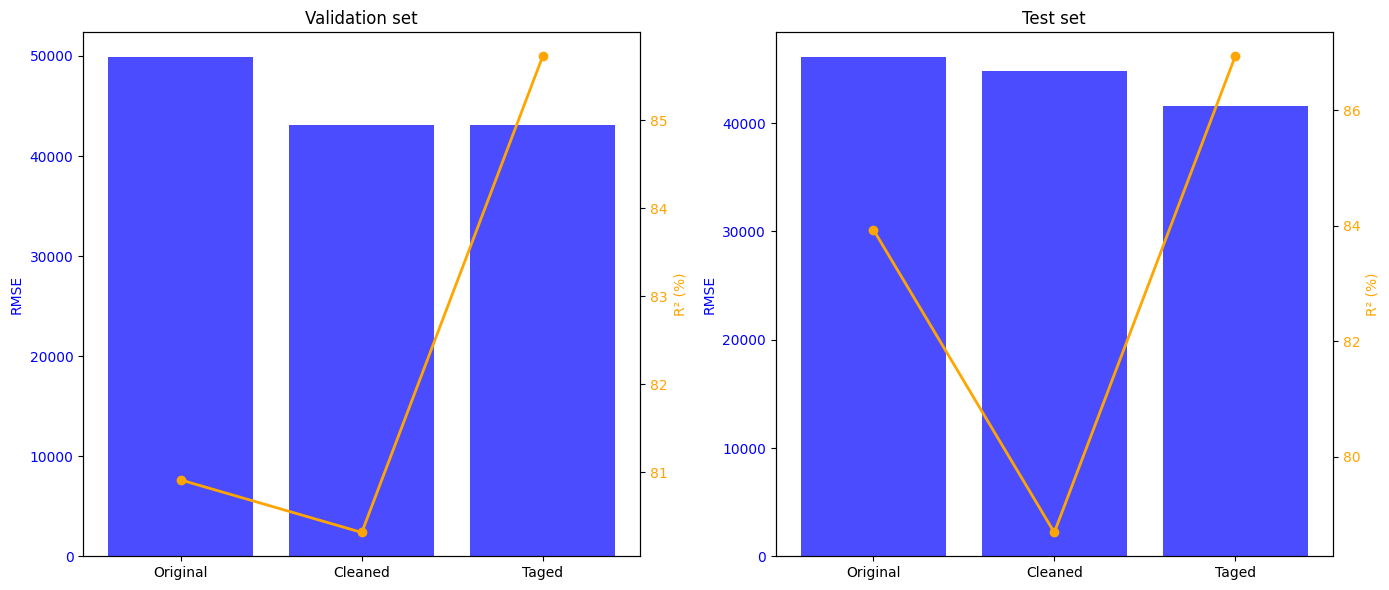

In [21]:
# Visualizing Results Comparison

methods = ['Original', 'Cleaned', 'Taged']
rmse_values_val = [val_rmse, val_cleaned_rmse, val_restored_rmse]
r2_values_val = [val_accuracy, val_cleaned_r2 * 100, val_restored_r2 * 100]

rmse_values_test = [test_rmse, test_cleaned_rmse, test_restored_rmse]
r2_values_test = [test_accuracy, test_cleaned_r2 * 100, test_restored_r2 * 100]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(methods, rmse_values_val, color='blue', alpha=0.7, label='RMSE')
axes[0].set_ylabel('RMSE', color='blue')
axes[0].tick_params(axis='y', labelcolor='blue')

ax2_val = axes[0].twinx()
ax2_val.plot(methods, r2_values_val, color='orange', marker='o', label='R² (%)', linewidth=2)
ax2_val.set_ylabel('R² (%)', color='orange')
ax2_val.tick_params(axis='y', labelcolor='orange')

axes[0].set_title('Validation set')

axes[1].bar(methods, rmse_values_test, color='blue', alpha=0.7, label='RMSE')
axes[1].set_ylabel('RMSE', color='blue')
axes[1].tick_params(axis='y', labelcolor='blue')

ax2_test = axes[1].twinx()
ax2_test.plot(methods, r2_values_test, color='orange', marker='o', label='R² (%)', linewidth=2)
ax2_test.set_ylabel('R² (%)', color='orange')
ax2_test.tick_params(axis='y', labelcolor='orange')

axes[1].set_title('Test set')

plt.tight_layout()
plt.show()